In [1]:
import anndata as ad
import scanpy as sc
import scvi
import muon as mu
import os
import pandas as pd
import numpy as np
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/code')
import useful_functions as uf
import sys
print(sys.executable)
import torch
import gdown
import warnings

#warnings
warnings.simplefilter(action='ignore')
#figures
sc.set_figure_params(frameon=False, figsize=(4, 4), dpi=150, fontsize = 5)
#set seeds for reproducibility
scvi.settings.seed = 100
#torch
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

Global seed set to 0
/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
Global seed set to 100


/home/jovyan/my-conda-envs/myenv/bin/python


In [2]:
import warnings
warnings.filterwarnings('ignore')
#this will hide the awful pandas deprec warnings that are currently plaguing scanpy

#now print versions
print(sc.__version__)
print(ad.__version__)
print(scvi.__version__)
print(pd.__version__)
print(np.__version__)
print(mu.__version__)

1.8.2
0.8.0
0.19.0
1.5.1
1.22.4
0.1.2


In [3]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/trained/10X_multiome')
adata = sc.read_h5ad('multivi_atlas_model/adata.h5ad')

In [4]:
#change obs names back
import re
pstr = "_paired"
adata.obs_names = [re.sub(pstr, "", x) for x in adata.obs_names.values]

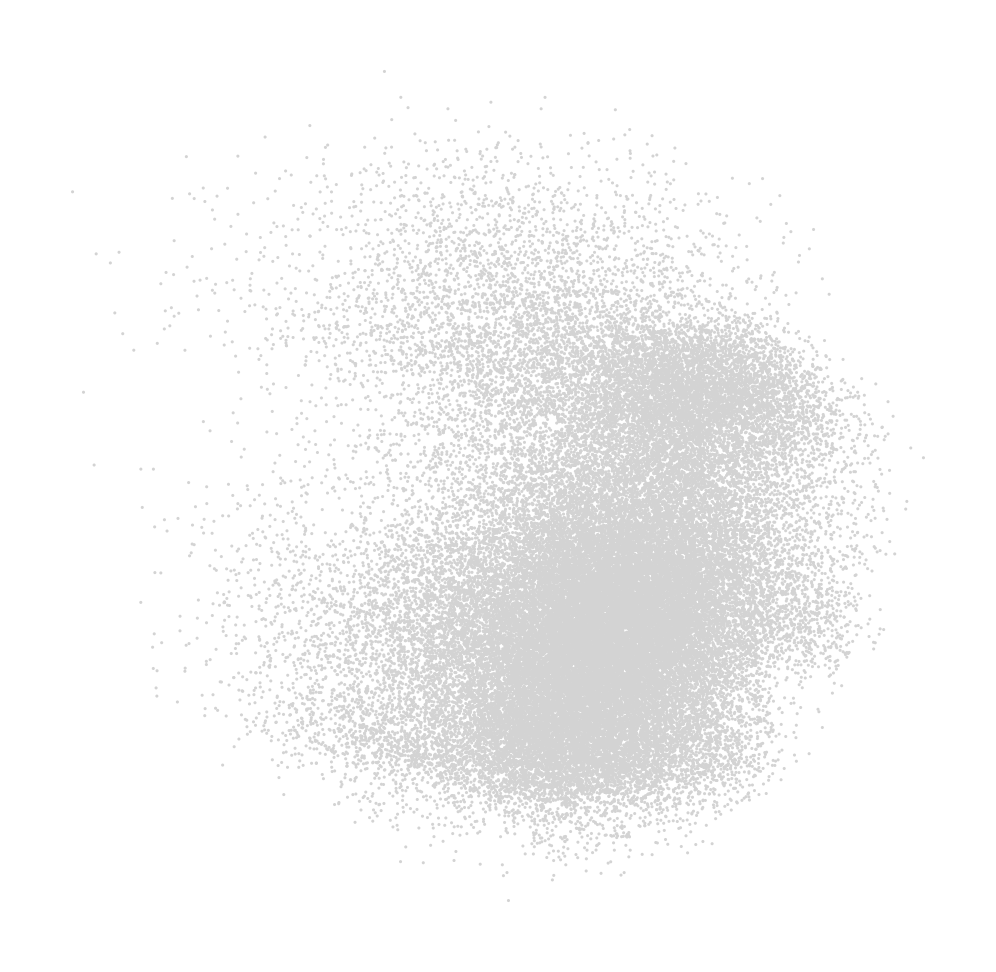

In [5]:
sc.pl.embedding(adata ,basis = "X_mVI")

In [6]:
sc.pp.neighbors(adata, use_rep= 'X_mVI', n_neighbors = 10)

In [7]:
sc.tl.umap(adata, min_dist = 0.3)

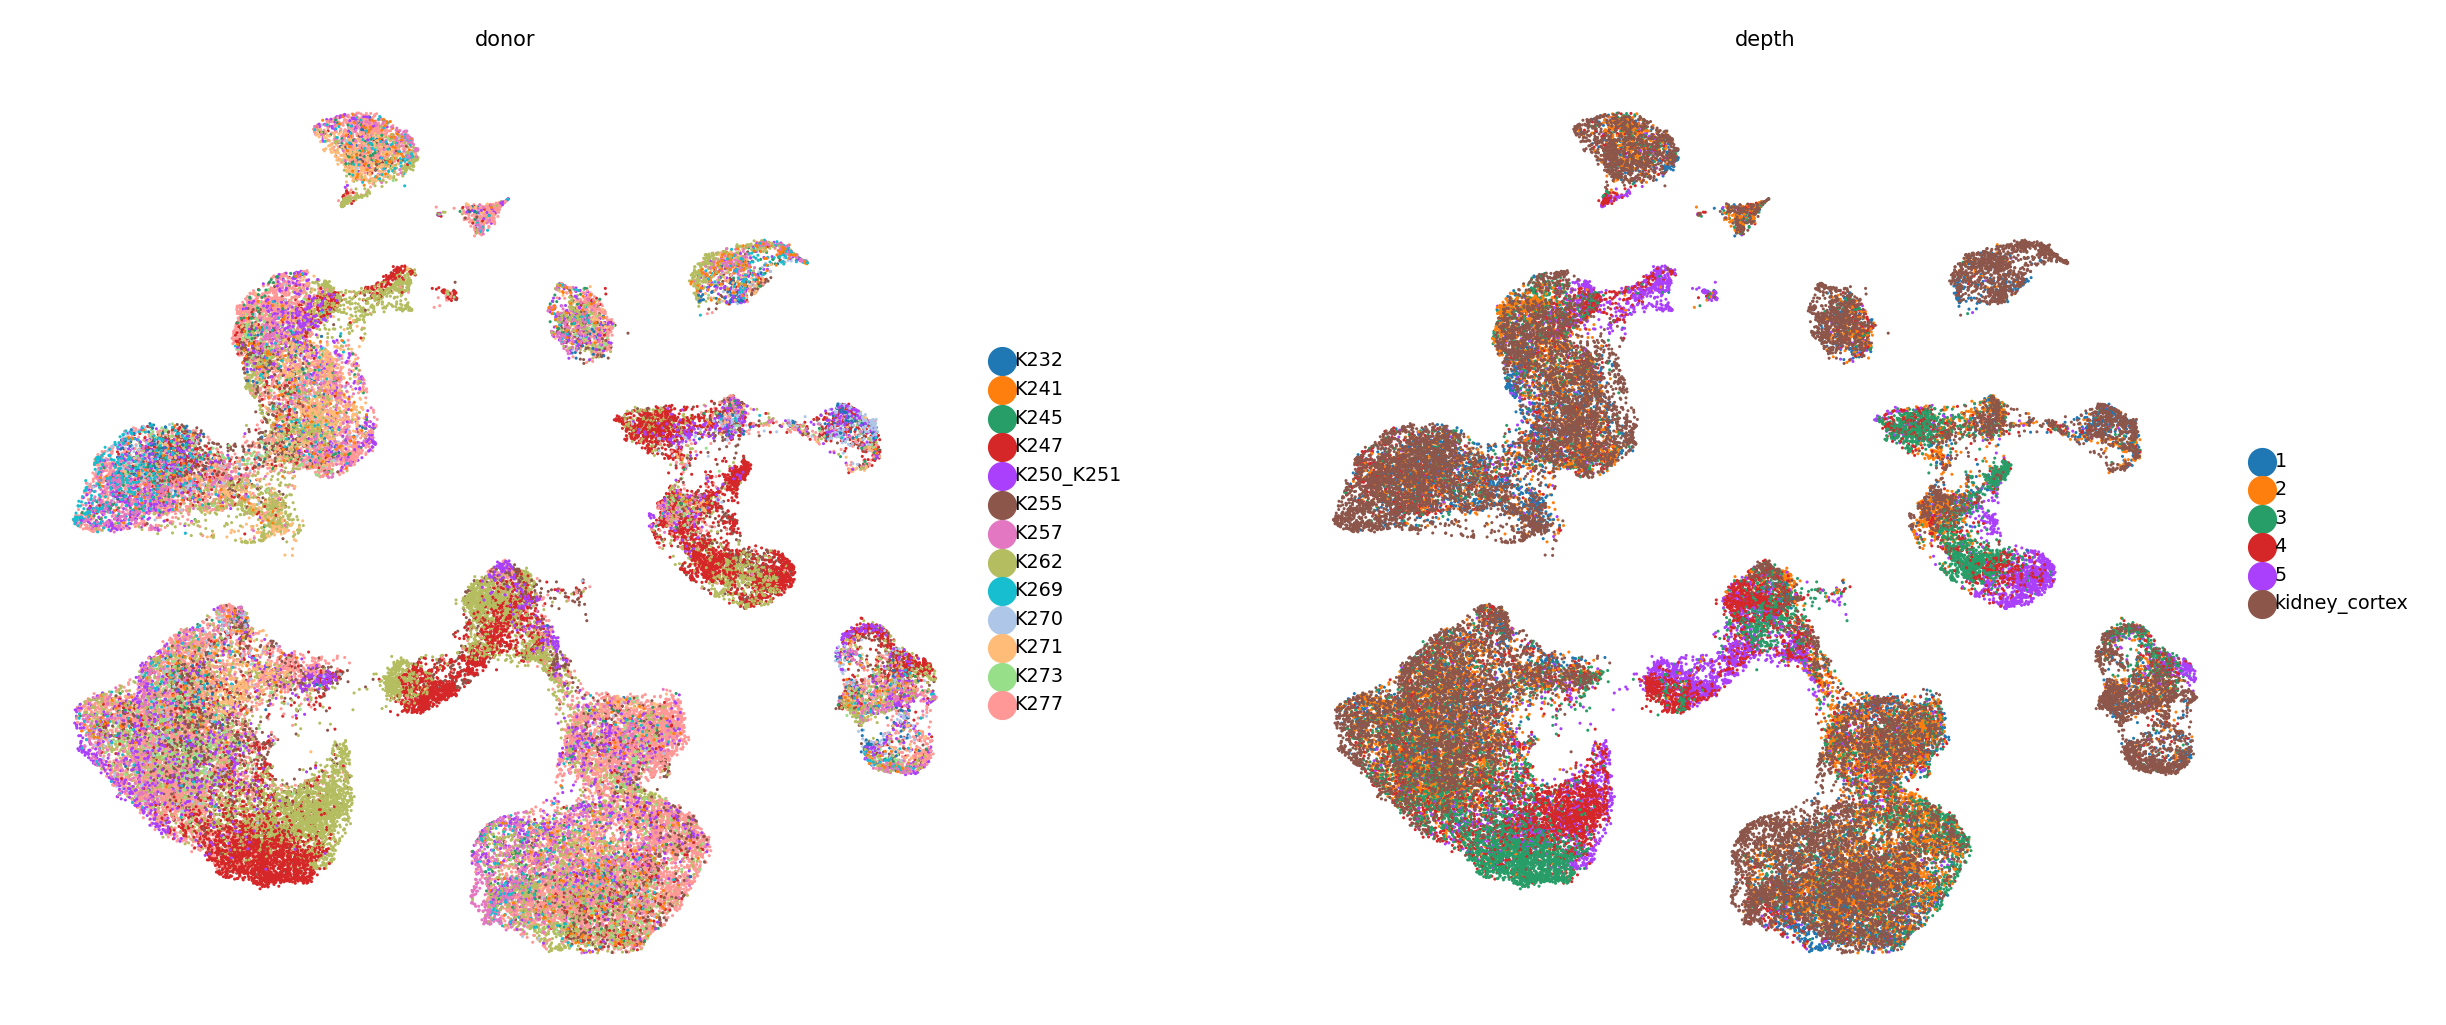

In [8]:
sc.pl.umap(adata, color = ['donor', 'depth'])

In [9]:
sc.tl.leiden(adata, resolution = 0.7)

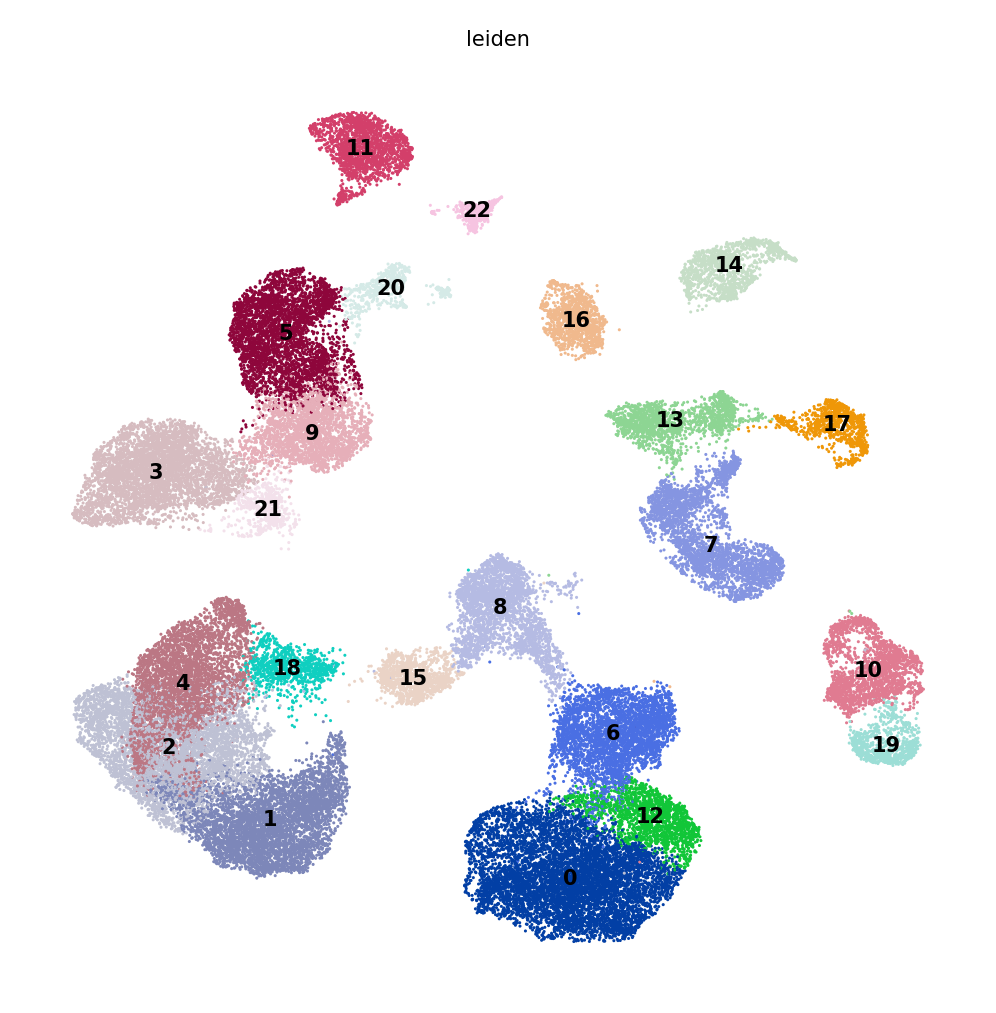

In [10]:
sc.pl.umap(adata, color = 'leiden', legend_loc = 'on data')

In [11]:
#subcluster a few of these
adata.obs['celltype_clusters'] = adata.obs['leiden']
#these need clustering at a lower resolution
for comp in ['20', '22', '4']:
    print(comp)
    sc.tl.leiden(adata, restrict_to = ('celltype_clusters', [comp]), resolution = 0.1)
    adata.obs['celltype_clusters'] = adata.obs['leiden_R']#these need clustering at a higher resolution
for comp in ['10', '7', '17', '13']:
    print(comp)
    sc.tl.leiden(adata, restrict_to = ('celltype_clusters', [comp]), resolution = 0.3)
    adata.obs['celltype_clusters'] = adata.obs['leiden_R']


20
22
4
10
7
17
13


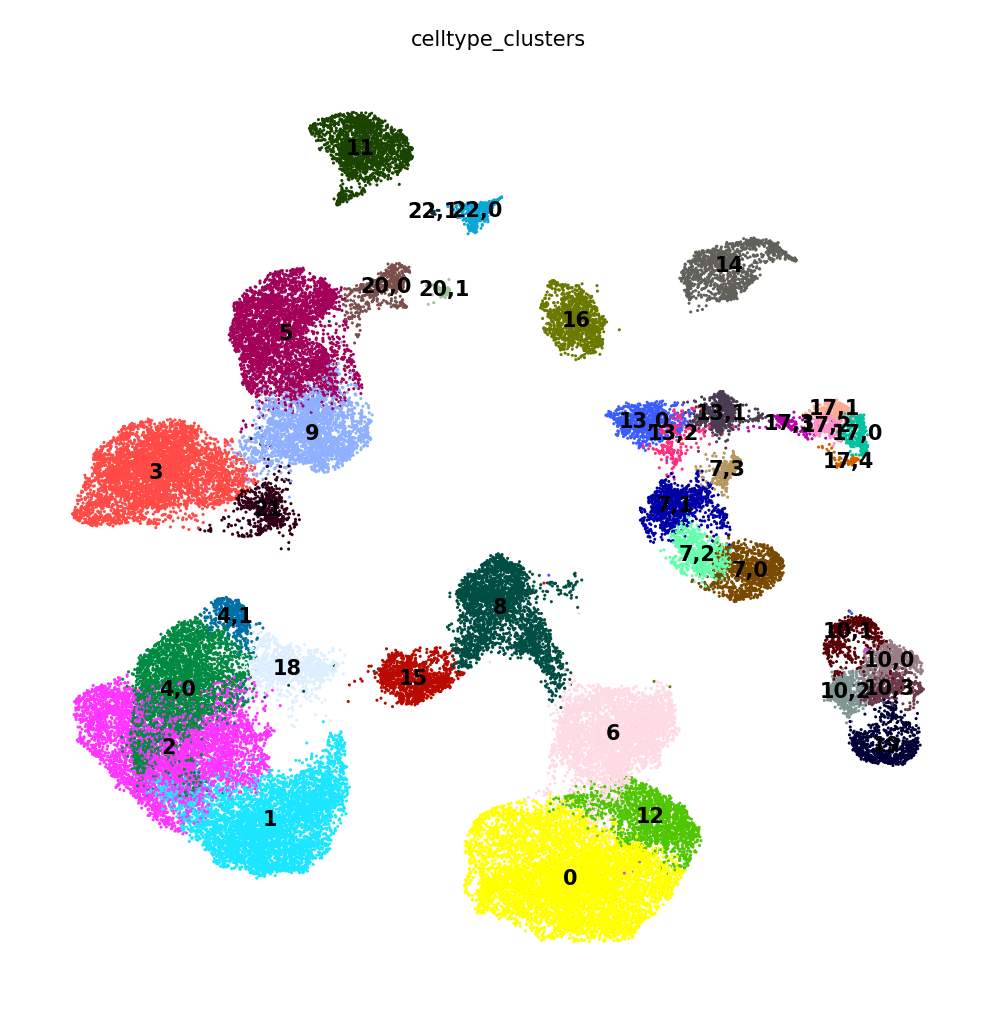

In [12]:
sc.set_figure_params(frameon=False, figsize=(4, 4), dpi=150, fontsize = 5)
sc.pl.umap(adata, color = 'celltype_clusters', legend_loc = 'on data')

In [13]:
#import geosketch as gs
#N = 10000 # Number of samples to obtain from the data set.
#idx = gs.gs(adata.obsm['X_mVI'], N, replace=False)
#adata.var['highly_variable'] = True #set as we have already subsetted
#adata.var['Symbol'] = adata.var_names
#adata.var['ID'] = adata.var_names
#subset_adata = adata[idx]
#markers = uf.get_markers(subset_adata[ :, adata.var['feature_types'].isin(['Gene Expression'])], 'celltype_clusters', layer = 'counts')

In [14]:
#markers['15'].head(10)

In [15]:
#cell types
celltype_map = {"0" : "convoluted_PTEC",
               "1" :  "medullary_TAL_LOH", #CLDN10
               "2" : "cortical_TAL_LOH",
               "3" : "DCT", #SLC12A3
               "4,0" : "cortical_TAL_LOH",
               "4,1" : "macula_densa", #ROBO2 #NOS1
               "5" : "PC", #AQP2
                "6" : "injured_PTEC", #VCAM1 #HAVCR1 
                "7,0" : "medullary_fibroblast",
                "7,1" : "cortical_fibroblast",
                "7,2" : "medullary_fibroblast",
                "7,3" : "VSMC",
                "8" :  "DTL_LOH", #ADGRL3
                "9" : "CNT",
                "10,0" : "VRE",
                "10,1" : "AE",
                "10,2" : "PCE",
                "10,3" : "PCE",
                "11" :  "IC_A", #SLC4A1
                "12" :  "straight_PTEC", #SLC5A8 #SLC5A10 #SLC5A1', 
                "13,0" :  "medullary_myofibroblast",
                "13,1" : "cortical_myofibroblast",
                "13,2" : "cortical_myofibroblast",
                "14" : "podocyte",
                "15" : "ATL_LOH", #SH3GL3 #PROX1
                "16" : "GPEC", #CFH #VCAM1 
                "17,0": "MC",
                "17,1" : "MC",
                "17,2" : "MC",
                "17,3" : "JGA",
                "17,4" : "MC",
                "18" : "cortical_TAL_LOH",  #CLDN16 
                "19" : "GEC",
                "20,0" :  "PE", #KRT19 #FXYD4
                "20,1" : "urothelium", #UPK1A #S100P #TP63 #GPX2
                "21" : "DCT",
                "22,0" : "IC_B", #SLC4A9
                "22,1" : "tissue_macrophage" #CD14 #PTPRC #C1QC
               }
 
# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['cell_type'] = adata.obs['celltype_clusters'].map(celltype_map).astype('category')

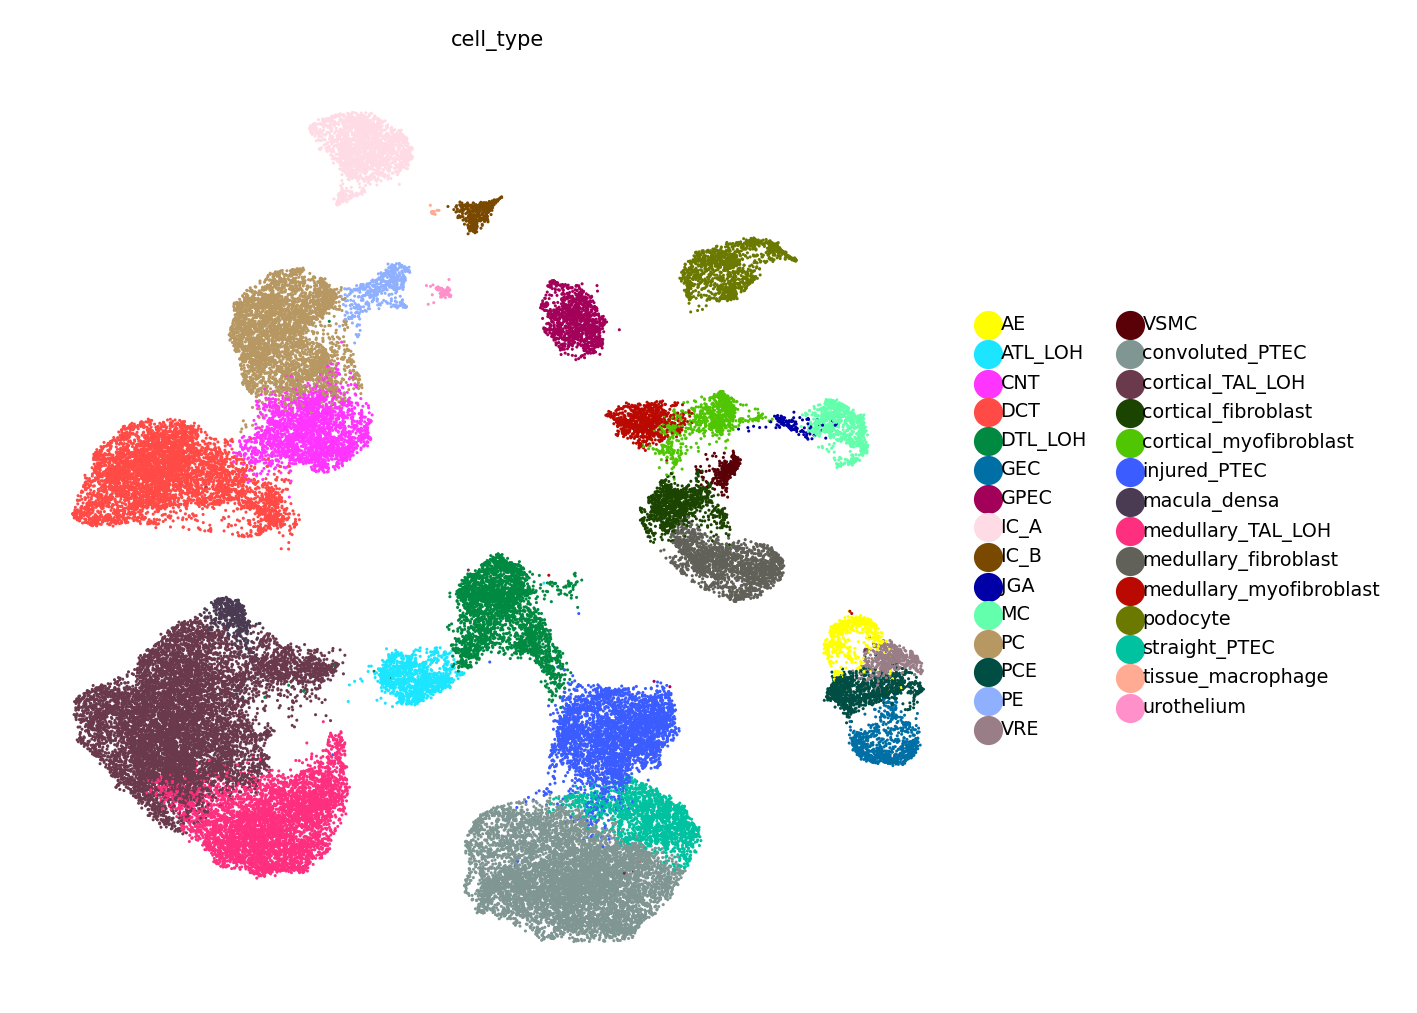

In [16]:
sc.pl.umap(adata, color = 'cell_type')

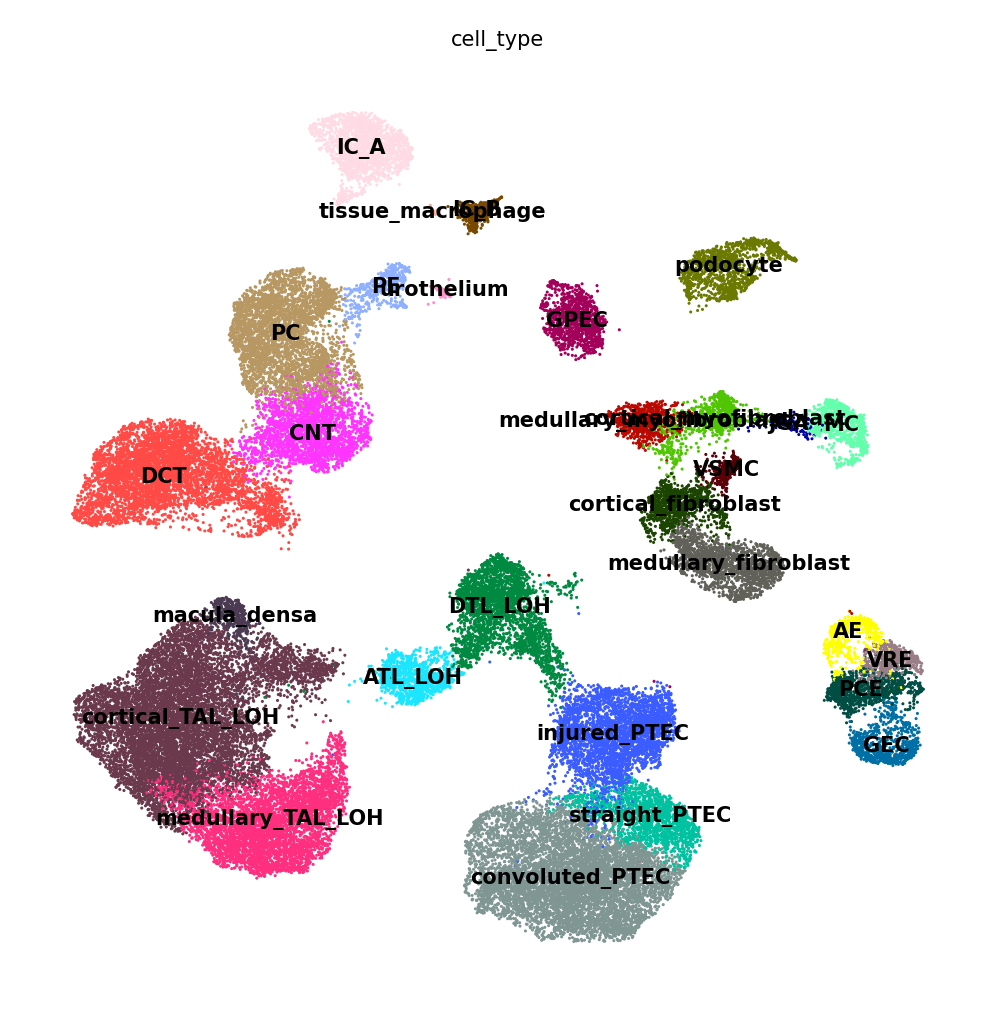

In [17]:
sc.pl.umap(adata, color = 'cell_type', legend_loc = 'on data')

In [18]:
#make the cell types categorical
ct_categories = [
    'podocyte',
    'GPEC',
    'convoluted_PTEC', 'straight_PTEC', 'injured_PTEC',
    'DTL_LOH', 'ATL_LOH', 'medullary_TAL_LOH', 'cortical_TAL_LOH', 'macula_densa',
    'DCT', 'CNT', 'PC',
    'IC_A', 'IC_B', 'PE', 'urothelium',
    'AE', 'GEC', 'VRE', 'PCE', 
    'MC', 'JGA', 'cortical_myofibroblast', 'medullary_myofibroblast', 'cortical_fibroblast', 'medullary_fibroblast', 'VSMC', 'tissue_macrophage'
]
adata.obs['cell_type'] = pd.Categorical(adata.obs['cell_type'], categories=ct_categories)

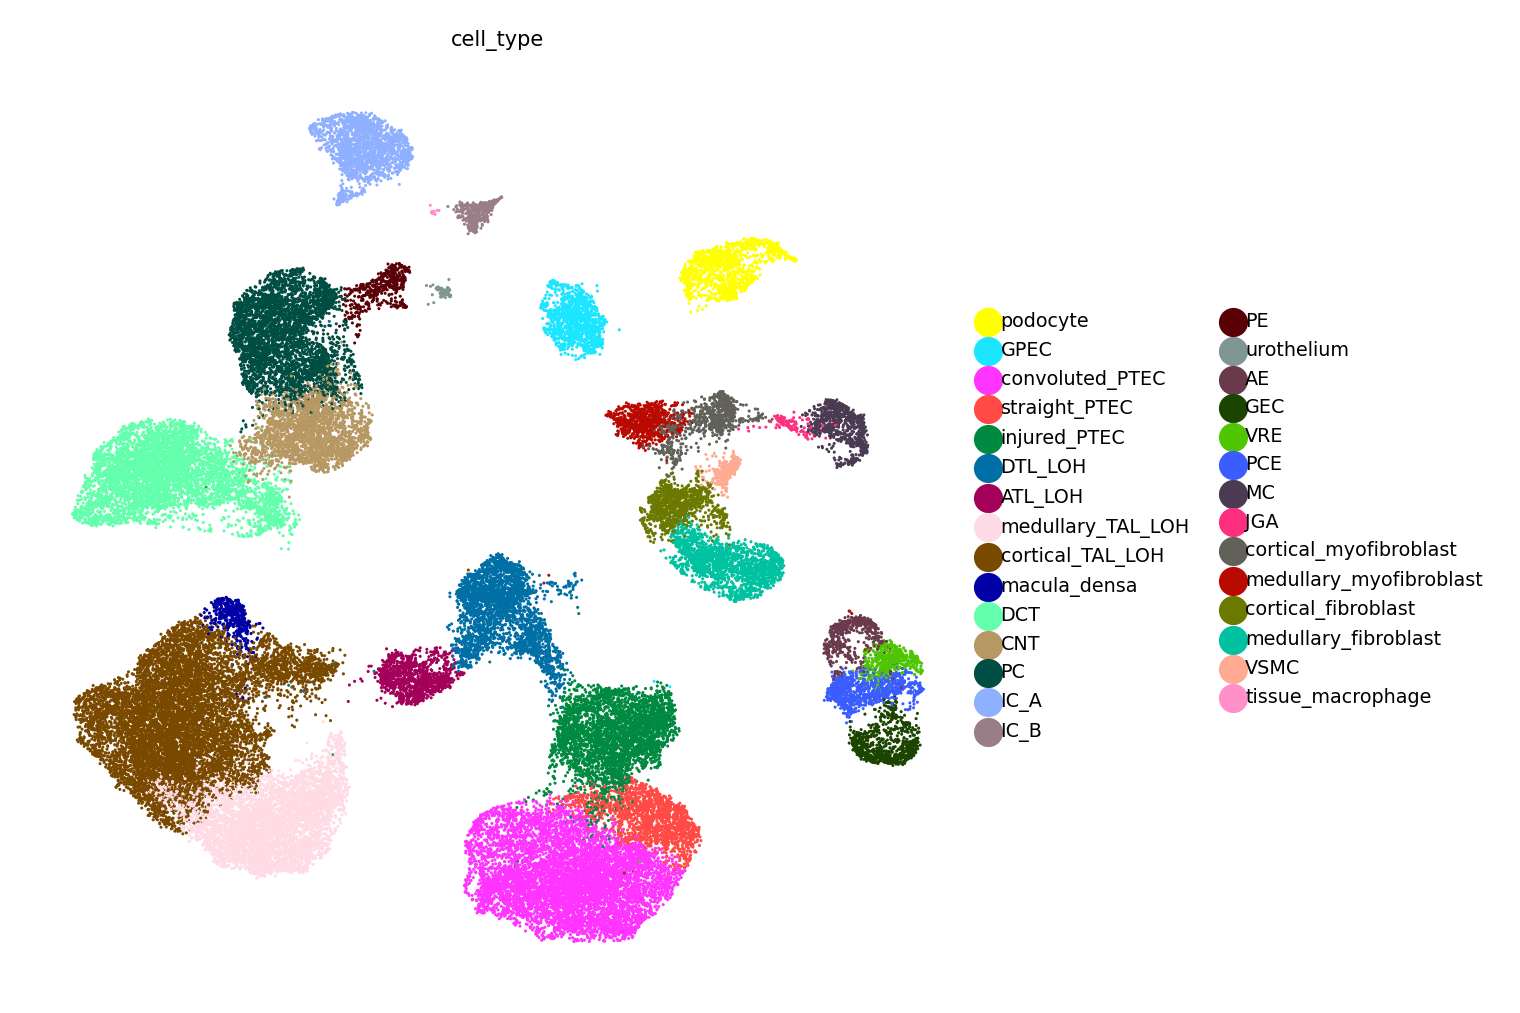

In [19]:
sc.pl.umap(adata, color = 'cell_type')

In [20]:
#do compartments
compartment_map = {  'podocyte' : "nephron",
    'GPEC': "nephron",
    'convoluted_PTEC': "nephron", 'straight_PTEC': "nephron", 'injured_PTEC': "nephron",
    'DTL_LOH': "nephron", 'ATL_LOH': "nephron", 'medullary_TAL_LOH': "nephron", 'cortical_TAL_LOH': "nephron", 'macula_densa': "nephron",
    'DCT': "nephron", 'CNT': "nephron", 'PC': "nephron",
    'IC_A': "nephron", 'IC_B': "nephron", 'PE': "nephron", 'urothelium': "nephron",
    'AE': "endothelium", 'GEC': "endothelium", 'VRE': "endothelium", 'PCE': "endothelium", 
    'MC': "stroma", 'JGA': "stroma", 'cortical_myofibroblast': "stroma", 'medullary_myofibroblast': "stroma", 
                   'cortical_fibroblast': "stroma", 'medullary_fibroblast': "stroma", 'VSMC' : 'stroma', 'tissue_macrophage': "immune_myeloid"
}
# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['compartment'] = adata.obs['cell_type'].map(compartment_map).astype('category')

In [21]:
#get broad cell types
bct_map = {  'podocyte' : "podocyte",
    'GPEC': "GPEC",
    'convoluted_PTEC': "PTEC", 'straight_PTEC': "PTEC", 'injured_PTEC': "PTEC",
    'DTL_LOH': "DTL_LOH", 'ATL_LOH': "ATL_LOH", 'medullary_TAL_LOH': "TAL_LOH", 'cortical_TAL_LOH': "TAL_LOH", 'macula_densa': "macula_densa",
    'DCT': "DCT", 'CNT': "CNT", 'PC': "PC",
    'IC_A': "IC", 'IC_B': "IC", 'PE': "PE", 'urothelium': "urothelium",
    'AE': "AE", 'GEC': "GEC", 'VRE': "VRE", 'PCE': "PCE", 
    'MC': "MC", 'JGA': "JGA", 'cortical_myofibroblast': "Mfib", 'medullary_myofibroblast': "Mfib", 
                   'cortical_fibroblast': "Fib", 'medullary_fibroblast': "Fib", 'VSMC' : 'VSMC', 'tissue_macrophage': "tissue_macrophage"
}
# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['broad_cell_type'] = adata.obs['cell_type'].map(bct_map).astype('category')

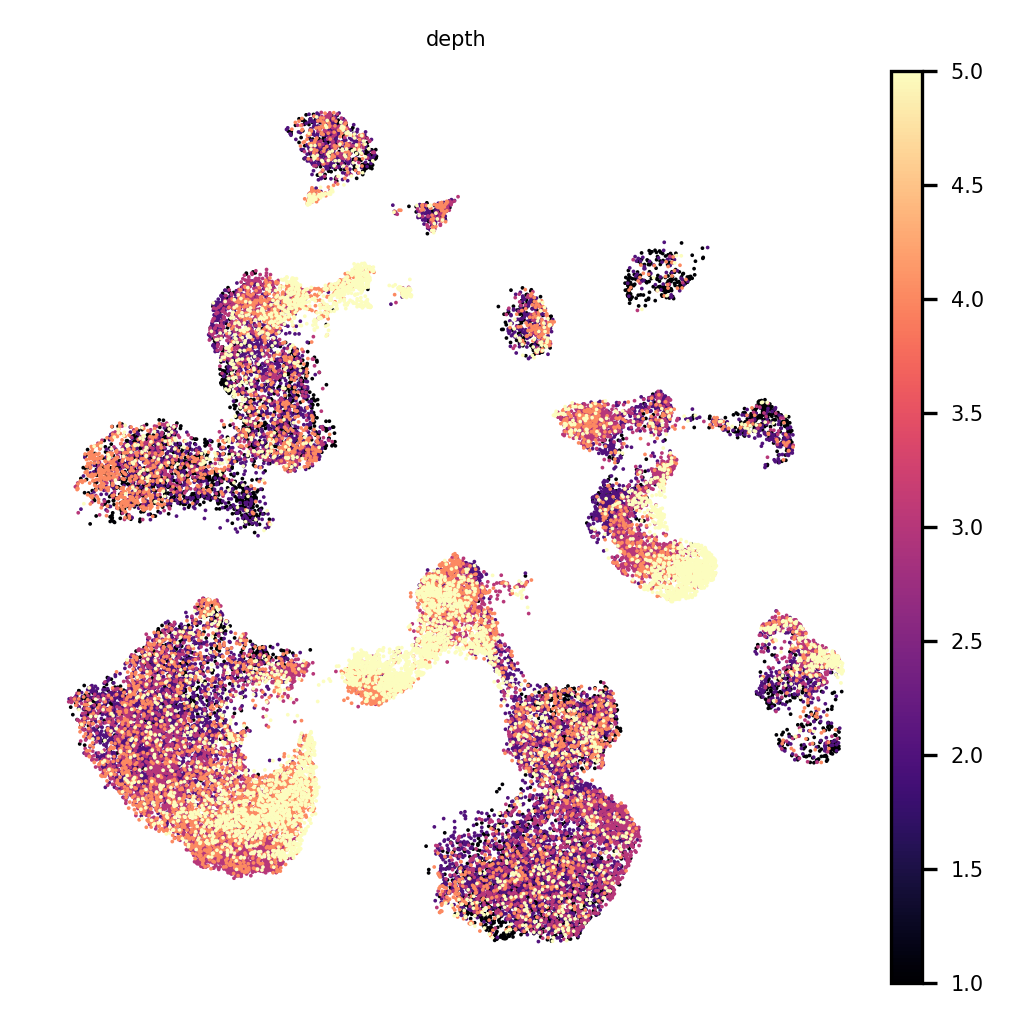

In [22]:
#plot by depth
depth_adata = adata[adata.obs['depth'].isin(['1', '2','3','4','5'])]
depth_adata.obs['depth'] = pd.to_numeric(depth_adata.obs['depth'] )
sc.pl.umap(depth_adata, color = 'depth', cmap = 'magma')

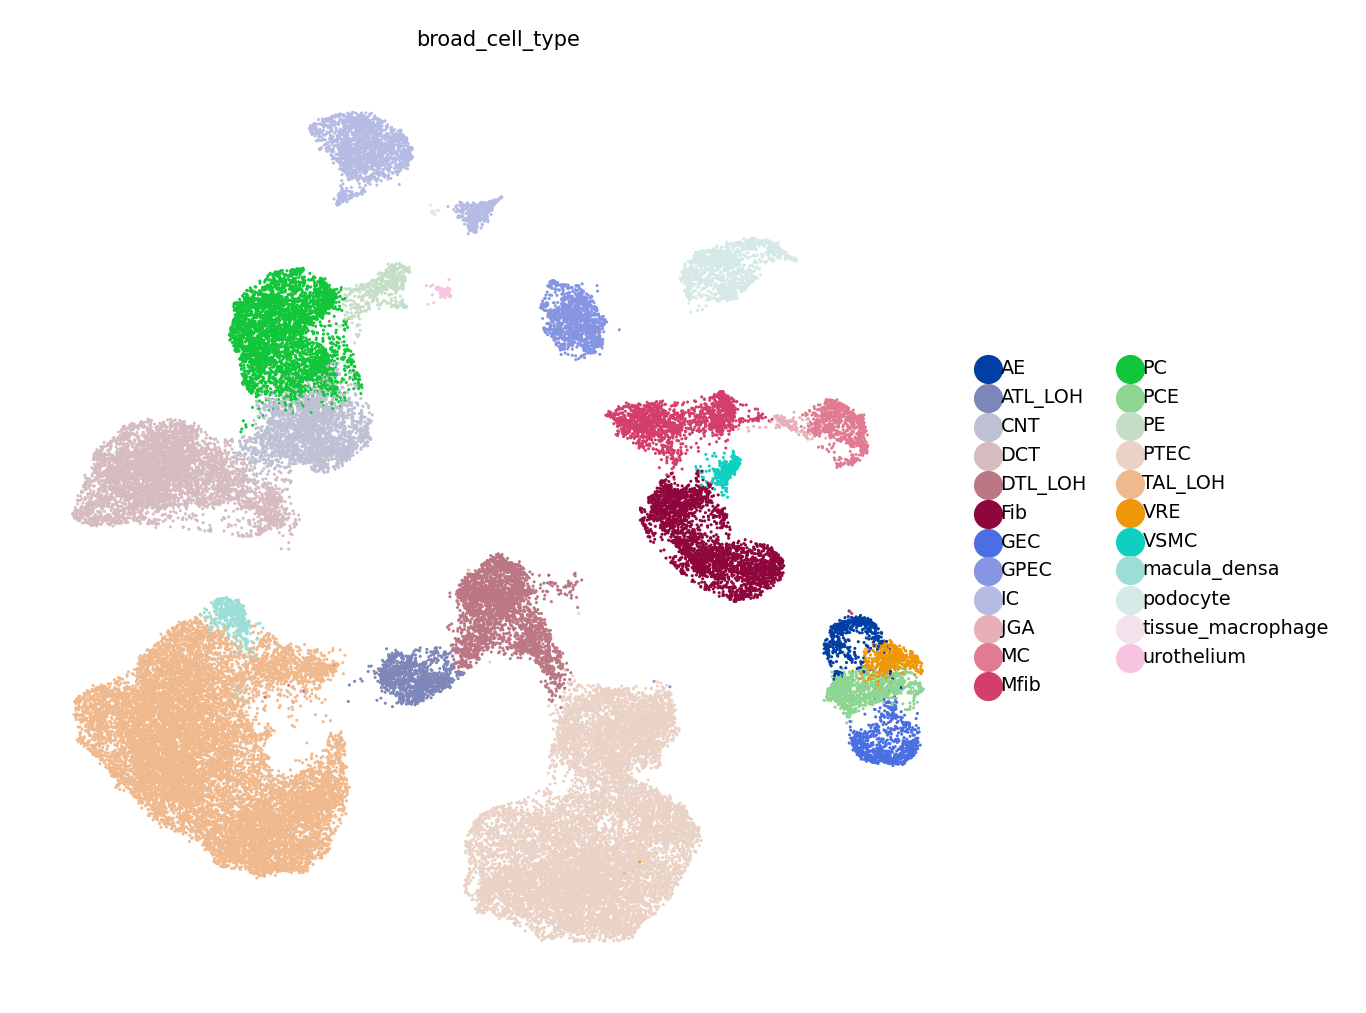

In [23]:
sc.pl.umap(adata, color = 'broad_cell_type')

In [24]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response')
adata.write_h5ad("./data/annotated/multiome_adata.h5ad")